# Improving Linear Regression with Neural Networks (Logistic Regression)

For this recipe, we will load the low birth-weight data and use a neural network with two hidden fully connected layers with sigmoid activations to  t the probability of a low birth- weight.




This function shows how to use TensorFlow to solve logistic regression with a multiple layer neural network
 $\textbf{y} = sigmoid(\textbf{A}_{3} \times sigmoid(\textbf{A}_{2} \times sigmoid(\textbf{A}_{1} \times \textbf{x} + \textbf{b}_{1}) + \textbf{b}_{2}) + \textbf{b}_{3})$

We will use the low birth weight data, specifically:
```
  y = 0 or 1 = low birth weight
  x = demographic and medical history data
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
import os.path
import csv
from tensorflow.python.framework import ops

# reset computational graph
ops.reset_default_graph()

## Obtain and prepare data for modeling

In [2]:
# name of data file
birth_weight_file = 'birth_weight.csv'

# download data and create data file if file does not exist in current directory
if not os.path.exists(birth_weight_file):
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
    with open(birth_weight_file, "w") as f:
        writer = csv.writer(f)
        writer.writerows(birth_data)
        f.close()

```
LIST OF VARIABLES: 
Columns   Variable                                              Abbreviation
-----------------------------------------------------------------------------
11-12   Pair Number                                             PAIR
   
19      Low Birth Weight (0 = Birth Weight ge 2500g,            LOW
                          l = Birth Weight < 2500g)
  
25-26   Age of the Mother in Years                              AGE
     
31-33   Weight in Pounds at the Last Menstrual Period           LWT
     
41      Race (1 = White, 2 = Black, 3 = Other)                  RACE
     
50      Smoking Status During Pregnancy (1 = Yes, 0 = No)       SMOKE
     
57      History of Premature Labor (0 = None, 1 = Yes)          PTL
     
63      History of Hypertension (1 = Yes, 0 = No)               HT
     
69      Presence of Uterine Irritability (1 = Yes, 0 = No)      UI
     
-----------------------------------------------------------------------------
```
Ref: https://www.mtech.edu/academics/clsps/math/Data%20Links/bwt.txt

In [3]:
import pandas as pd
df = pd.read_csv(birth_weight_file,names = ["LOW","AGE", "LWT","FTV","SMOKE","PTL","HT","UI","BWT"])
df.head(5)

,LOW,AGE,LWT,FTV,SMOKE,PTL,HT,UI,BWT
0,1.0,28.0,113.0,1.0,1.0,1.0,0.0,1.0,709.0
1,1.0,29.0,130.0,0.0,0.0,0.0,0.0,1.0,1021.0
2,1.0,34.0,187.0,1.0,1.0,0.0,1.0,0.0,1135.0
3,1.0,25.0,105.0,1.0,0.0,1.0,1.0,0.0,1330.0
4,1.0,25.0,85.0,1.0,0.0,0.0,0.0,1.0,1474.0


In [4]:
# read birth weight data into memory
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        birth_data.append(row)
birth_data = [[float(x) for x in row] for row in birth_data]
# print(birth_data)

In [5]:
# Pull out target variable
y_vals = np.array([x[0] for x in birth_data])
# Pull out predictor variables (not id, not target, and not birthweight)
x_vals = np.array([x[1:8] for x in birth_data])
print(y_vals)
print(x_vals)
print(x_vals.shape)
print(y_vals.shape)# (1,188)
print(np.transpose([y_vals]).shape)# (188,1)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[[  28.  113.    1. ...,    1.    0.    1.]
 [  29.  130.    0. ...,    0.    0.    1.]
 [  34.  187.    1. ...,    0.    1.    0.]
 ..., 
 [  19.  120.    0. ...,    0.    1.    0.]
 [  24.  216.    0. ...,    0.    0.    0.]
 [  4

In [6]:
#set for reproducible results
seed = 99
np.random.seed(seed)
tf.set_random_seed(seed)

In [7]:
# Declare batch size
batch_size = 90

In [8]:
# Split data into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [9]:
# Normalize by column (min-max norm)
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)

In [10]:
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

## Define Tensorflow computational graph

In [11]:
# Create graph
sess = tf.Session()

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 7], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)


# Create variable definition
def init_variable(shape):
    return(tf.Variable(tf.random_normal(shape=shape)))


# Create a logistic layer definition
def logistic(input_layer, multiplication_weight, bias_weight, activation = True):
    linear_layer = tf.add(tf.matmul(input_layer, multiplication_weight), bias_weight)
    # We separate the activation at the end because the loss function will
    # implement the last sigmoid necessary
    if activation:
        return(tf.nn.sigmoid(linear_layer))
    else:
        return(linear_layer)


# First logistic layer (7 inputs to 7 hidden nodes)
A1 = init_variable(shape=[7,14])
b1 = init_variable(shape=[14])
logistic_layer1 = logistic(x_data, A1, b1)

# Second logistic layer (7 hidden inputs to 5 hidden nodes)
A2 = init_variable(shape=[14,5])
b2 = init_variable(shape=[5])
logistic_layer2 = logistic(logistic_layer1, A2, b2)

# Final output layer (5 hidden nodes to 1 output)
A3 = init_variable(shape=[5,1])
b3 = init_variable(shape=[1])
final_output = logistic(logistic_layer2, A3, b3, activation=False)

# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=final_output, labels=y_target))

# Declare optimizer
my_opt = tf.train.AdamOptimizer(learning_rate = 0.002)
train_step = my_opt.minimize(loss)

## Train model

In [12]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Actual Prediction
prediction = tf.round(tf.nn.sigmoid(final_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
# sess = tf.Session()
# print(sess.run(tf.cast(tf.equal([1,2], [1,1]), tf.float32)))
accuracy = tf.reduce_mean(predictions_correct)

writer = tf.summary.FileWriter("ImproveLinear/", graph = sess.graph)

# Training loop
loss_vec = []
train_acc = []
test_acc = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    temp_acc_train = sess.run(accuracy, feed_dict={x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_acc_train)
    temp_acc_test = sess.run(accuracy, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)
    if (i+1)%150==0:
        print('Loss = ' + str(temp_loss))
sess.close()

Loss = 0.594851
Loss = 0.58907
Loss = 0.573354
Loss = 0.520678
Loss = 0.543256
Loss = 0.504689
Loss = 0.511246
Loss = 0.575412
Loss = 0.55366
Loss = 0.561518


## Display model performance

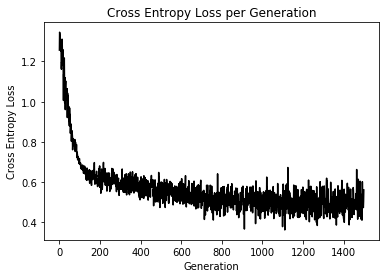

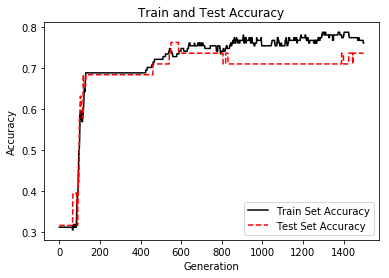

In [13]:
%matplotlib inline
# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()